## Classification Test

In [1]:
import os

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [3]:
from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn as nn
from torchvision.models import vgg19

import dataloader

In [4]:
valid_loader = dataloader.imagenet_loader(bs=32)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
model = vgg19(pretrained=True)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

In [7]:
def test_accuracy(epoch):
    top1_accuracy = 0.
    top5_accuracy = 0.
    loss = 0.

    model.eval()
    for idx, (inputs, targets) in tqdm_notebook(enumerate(valid_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets).detach().cpu().item()

        topk = outputs.topk(5,dim=1)[1]
        top1_accuracy += topk[:,0].eq(targets).sum().cpu().item()
        top5_accuracy += topk.eq(torch.stack([targets]*5,dim=1)).max(1)[0].sum().cpu().item()
    
    top1_accuracy /= len(valid_loader.dataset)
    top5_accuracy /= len(valid_loader.dataset)
    loss /= len(valid_loader.dataset)

    print('Classification')
    print(f'===> Test Loss: {loss:.4f}, Top1-Acc: {top1_accuracy*100:.4f}, Top5-Acc: {top5_accuracy*100:.4f}')

In [8]:
test_accuracy(0) # ===> Test Loss: 0.0373, Top1-Acc: 70.6800, Top5-Acc: 89.9200

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cml/anaconda3/envs/torch/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/cml/anaconda3/envs/torch/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/cml/anaconda3/envs/torch/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/cml/anaconda3/envs/torch/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/cml/anaconda3/envs/torch/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/cml/anaconda3/envs/torch/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/cml/anaconda3/envs/torch/lib/python3.6/multiproces

KeyboardInterrupt: 

## Localization Test

In [ ]:
import json

In [ ]:
def save_json(directory, bboxes_cam, bboxes_ours):
    if not os.path.exists(directory):
        os.makedirs(directory)

    with open(join(directory,'cam.json'), 'a') as json_file:
        json.dump(bboxes_cam, json_file)

    with open(join(directory,'ours_0.2_10.json'), 'a') as json_file:
        json.dump(bboxes_ours, json_file)

In [ ]:
import os

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [ ]:
import os
import numpy as np
from PIL import Image
from os.path import join
from tqdm import tqdm, tqdm_notebook

from cam import CAM
import util

In [ ]:
map = CAM()

In [ ]:
data_dict = map.valid_dataset.data_dict
input_files = map.valid_dataset.img_files
img_dir = map.valid_dataset.img_dir

In [ ]:
bboxes_cam = {}
bboxes_ours = {}

count = 0
correct_cam = 0
correct_propose = 0
for data_idx in tqdm(range(len(data_dict))):
    count += 1
    
    # get true bbox
    input_file = input_files[data_idx]
    img_origin = Image.open(join(img_dir, input_file)).convert('RGB')
    bboxes_true = data_dict[input_file][1]
    bboxes_true = util.bboxes_resize(img_origin, bboxes_true, size=224)
    
    # get input and target
    input, target = map.get_item(data_idx)
    target = target.cpu().item()
    
    ''' CAM origin version '''
    _, _, _, _, bbox_pred = map.get_values(data_idx, target, th1=0.2, phase='test')
    
    ''' CAM propose version '''
    _, _, _, _, _, bbox_propose = map.get_values(data_idx, target, th1=0.2, th2=10, mc=50, phase='train')
    
    ''' get iou '''
    iou_preds, iou_propose = [], []
    for bbox_true in bboxes_true:
        iou_preds.append(util.get_iou(bbox_true, bbox_pred))
        iou_propose.append(util.get_iou(bbox_true, bbox_propose))
        
        
        correct_cam += max(np.array(iou_preds) >= 0.5).astype(np.int)
        correct_propose += max(np.array(iou_propose) >= 0.5).astype(np.int)
    
    ''' save bboxes for every 100 iteration '''
    bboxes_cam[input_file] = bbox_pred
    bboxes_ours[input_file] = bbox_propose
    
    if data_idx+1 % 100 == 0:
        save_json('bbox',bboxes_cam, bboxes_ours)
        bboxes_cam, bboxes_ours = {}, {}
    
#     if data_idx == 2:
#         break
        
print('Localization Accuracy')
print(f'===> CAM: {correct_cam/count}, Propose: {correct_propose/count}')

In [ ]:
bboxes_cam

In [ ]:
if not os.path.exists('bbox'):
    os.makedirs('bbox')
    
with open(join('bbox','cam.json'), 'a') as json_file:
    json.dump(bboxes_cam, json_file)
    
with open(join('bbox','ours_0.2_10.json'), 'a') as json_file:
    json.dump(bboxes_ours, json_file)

In [ ]:
500 * 2.5 / 60

## Save the plot

In [9]:
import os
from os.path import join
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm_notebook

from cam import CAM
import util

In [10]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [16]:
map = CAM()

class_dict = dataloader.get_class_dict('/data2/imagenet')[0]
data_dict = map.valid_dataset.data_dict
input_files = map.valid_dataset.img_files
img_dir = map.valid_dataset.img_dir

In [17]:
def save_result_plt(data_idx, th1=0.2, th2=10, mc=15):
    # get true bbox
    input_file = input_files[data_idx]
    img_origin = Image.open(join(img_dir, input_file)).convert('RGB')
    bboxes_true = data_dict[input_file][1]
    bboxes_true = util.bboxes_resize(img_origin, bboxes_true, size=224)
    
    # get input, target, and topk
    input, target = map.get_item(data_idx)
    target = target.cpu().item()

    topk_idxs = map.topk(input)
    top1_correct = target in topk_idxs[:1]
    top5_correct = target in topk_idxs[:5]
    
    att_idx = target
    
    # origin
    img, heatmap_origin, boolmap, boolmap_biggest, \
    bbox_pred = map.get_values(data_idx,att_idx, th1=0.2, phase='test')
    
    # propose
    _, heatmap_mean, heatmap_std, boolmap_propose, boolmap_biggest_propose, \
    bbox_propose = map.get_values(data_idx, att_idx, th1, th2, mc, phase='train')
    heatmap_std_max = heatmap_std.max()
    
    # save the plot
    fig, ax = plt.subplots(2,6,figsize=(21,7))

    ax[0,0].imshow(img)
    ax[0,0].set_title('origin')
    ax[0,0].axis('off')

    ax[0,1].imshow(heatmap_origin)
    ax[0,1].set_title('heatmap')
    ax[0,1].axis('off')

    ax[0,2].imshow(img)
    ax[0,2].imshow(heatmap_origin, alpha=0.5, cmap='jet')
    ax[0,2].set_title(f'CAM "{class_dict[target]}"\n Top-1: {top1_correct}, Top-5: {top5_correct}')
    ax[0,2].axis('off')

    ax[0,3].imshow(Image.fromarray((boolmap*255).astype(np.uint8)), cmap='gray')
    ax[0,3].set_title('boolean map')
    ax[0,3].axis('off')

    ax[0,4].imshow(Image.fromarray((boolmap_biggest*255).astype(np.uint8)), cmap='gray')
    ax[0,4].set_title('biggest boolean map')
    ax[0,4].axis('off')

    ax[0,5].imshow(img)
    for bbox_true in bboxes_true:
        rect_true = patches.Rectangle((bbox_true[0],bbox_true[1]),bbox_true[2],bbox_true[3],
                                      linewidth=2,edgecolor='g',facecolor='none')
        ax[0,5].add_patch(rect_true)
    rect_pred = patches.Rectangle((bbox_pred[0],bbox_pred[1]),bbox_pred[2],bbox_pred[3],
                                  linewidth=2,edgecolor='r',facecolor='none')
    ax[0,5].add_patch(rect_pred)
    ax[0,5].set_title('bounding box')
    ax[0,5].axis('off')


    ax[1,0].imshow(heatmap_mean, cmap='gray')
    ax[1,0].set_title('heatmap_mean')
    ax[1,0].axis('off')

    ax[1,1].imshow(heatmap_std, cmap='gray')
    ax[1,1].set_title(f'heatmap_std\n max value: {heatmap_std_max:.01f}')
    ax[1,1].axis('off')

    im1 = ax[1,2].imshow(heatmap_mean, cmap='Reds', label='mean')
    im2 = ax[1,2].imshow(heatmap_std, cmap='Blues', label='std', alpha=0.5)
    ax[1,2].set_title('overlap')
    ax[1,2].axis('off')
    patch = [patches.Patch(color=im1.cmap(150), label='mean'), 
             patches.Patch(color=im2.cmap(150), label='std')]
    ax[1,2].legend(handles=patch, loc='best')

    ax[1,3].imshow(Image.fromarray((boolmap_propose*255).astype(np.uint8)), cmap='gray')
    ax[1,3].set_title('boolean map')
    ax[1,3].axis('off')

    ax[1,4].imshow(Image.fromarray((boolmap_biggest_propose*255).astype(np.uint8)), cmap='gray')
    ax[1,4].set_title('biggest boolean map')
    ax[1,4].axis('off')

    ax[1,5].imshow(img)
    for bbox_true in bboxes_true:
        rect_true = patches.Rectangle((bbox_true[0],bbox_true[1]),bbox_true[2],bbox_true[3],
                                      linewidth=2,edgecolor='g',facecolor='none')
        ax[1,5].add_patch(rect_true)
    rect_pred = patches.Rectangle((bbox_propose[0],bbox_propose[1]),bbox_propose[2],bbox_propose[3],
                                  linewidth=2,edgecolor='r',facecolor='none')
    ax[1,5].add_patch(rect_pred)
    ax[1,5].set_title('bounding box')
    ax[1,5].axis('off')

    plt.show()
#     plt.savefig(join('save',f'{data_idx:05d}.png'))
#     plt.close(fig)

In [8]:
# for data_idx in tqdm_notebook(range(1000)):
#     save_result_plt(data_idx, th1=0.4, th2=0.4, mc=30)

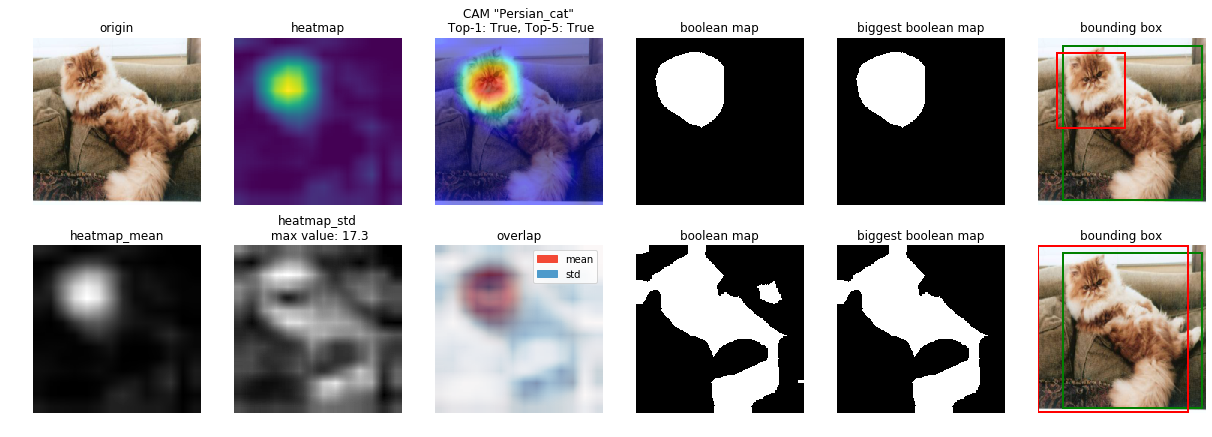

In [22]:
save_result_plt(129,th1=0.4, th2=0.4, mc=50) # good hyperparam... maybe! th1=0.4, th2=0.4, mc=50 